In [1]:
#Código que lee el archivo en pdf y lo divide en capítulos
import re
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer
import os

pagina_inicio_capitulos = 55

def extraer_texto_por_capitulos(archivo_pdf):
    texto_completo = ""
    with open(archivo_pdf, 'rb') as file:
        for i, page_layout in enumerate(extract_pages(file)):
            if i < pagina_inicio_capitulos - 1:  # Restamos 1 porque el índice comienza en 0
                continue
            for element in page_layout:
                if isinstance(element, LTTextContainer):
                    texto_completo += element.get_text()

    # Reemplazamos múltiples espacios con uno solo
    texto_completo = re.sub(r'\s+', ' ', texto_completo)

    capitulos = re.split(r'Chapter\s*\d+', texto_completo, flags=re.IGNORECASE)
    capitulos = capitulos[1:]
    return capitulos

archivo = "the lord of the rings.pdf"
capitulos = extraer_texto_por_capitulos(archivo)

print(len(capitulos))

22


In [2]:
#Creamos el código que nos genera los sinónimos
import networkx as nx
import spacy
import matplotlib.pyplot as plt
from nltk.corpus import wordnet

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

def generar_red_semantica(text):
    # Procesamiento con Spacy
    doc = nlp(text)

    # Generación de la red semántica
    G = nx.Graph()

    mydict = {}
    # Recorremos cada frase del documento
    for sent in doc.sents:
        new_concepts = []
        # Recorremos cada token de la frase
        for token in sent:
            if token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ == "VERB" or token.pos_ == "ADV":
                # Creamos la lista vacía de sinónimos
                sinonimos = []
                # Sacamos los sinónimos del token
                for syn in wordnet.synsets(token.text.lower()):
                    for lemma in syn.lemmas():
                        # Agregamos sinónimos solo si son diferentes a la palabra original para no agregar la propia palabra 
                        if lemma.name() != token.lemma_.lower():
                            sinonimos.append(lemma.name())
                # Creamos la variable sinonimo_encontrado en None
                sinonimo_encontrado = None
                # Recorremos la lista de sinónimos
                for sinonimo in sinonimos:
                    # Si el sinónimo se encuentra en las claves de mi diccionario la variable creada será el sinónimo
                    if sinonimo in mydict:
                        sinonimo_encontrado = sinonimo
                        break
                # Si encontramos un sinónimo, si el token no está en los valores del diccionario de la clave del sinónimo lo agregamos
                if sinonimo_encontrado:
                    # Agregamos a la lista de conceptos el sinónimo del token (puesto que ya es un nodo del grafo)
                    new_concepts.append(sinonimo)
                    if token.lemma_.lower() not in mydict[sinonimo_encontrado]:
                        mydict[sinonimo_encontrado].append(token.lemma_.lower())
                # Si encontramos un sinónimo y no está en los atributos del nodo correspondiente lo agregamos como atributo
                    if token.lemma_.lower() not in G.nodes[sinonimo_encontrado].values():
                        G.nodes[sinonimo_encontrado][token.lemma_.lower()] = True

                # Si no encontramos sinónimos agregamos al diccionario como clave el token
                elif sinonimos:
                    mydict[token.lemma_.lower()] = [token.lemma_.lower()]
                # Si no encontramos sinónimos agregamos al grafo el token como nodo
                    G.add_node(token.lemma_.lower())
                # Agregamos al token a la lista de conceptos nuevos
                    new_concepts.append(token.lemma_.lower())
            # Agregamos las aristas recorriendo la lista 2 veces
            for i in new_concepts:
                for j in new_concepts:
                    if i != j:
                        G.add_edge(i, j)
    
    return G, mydict

In [3]:
#Creamos la lista con todas las redes juntas
redes_capitulos = []
hubs = []
for capitulo in capitulos:
    red, mydict = generar_red_semantica(capitulo)
    redes_capitulos.append(red)
    hubs.append(mydict)
valores_hubs = [list(dic.values()) for dic in hubs]

In [4]:
#sacamos los nodos totales en una lista de nodos por capitulo e imprimimos el total de nodos
nodos_totales = []
suma = 0
for red in redes_capitulos:
    nodos_por_capitulo = []
    for nodo in red.nodes:
        nodos_por_capitulo.append(nodo) 
        suma += 1
    nodos_totales.append(nodos_por_capitulo)
print(suma)

14030


In [5]:
#Vemos el total de nodos que tenemos sumando red a red(sin nodos repetidos)
nodos_unicos = set()

for red in redes_capitulos:
    for nodo in red.nodes:
        nodos_unicos.add(nodo)

suma_nodos_totales = len(nodos_unicos)
print(suma_nodos_totales)

4006


In [6]:
#Generamos los temas y sus topics usando el modelo LDA
from gensim import corpora
from gensim import models

factor_de_compresion = 0.01

# Creo un diccionario basado en los nodos por capítulo
dictionary = corpora.Dictionary(nodos_totales)

for i, nodos_por_capitulo in enumerate(nodos_totales):
    num_topics = int(len(nodos_por_capitulo) * factor_de_compresion)

    # Me aseguro de que num_topics sea al menos 1
    num_topics = max(num_topics, 1)

    # Creo un corpus utilizando la representación de bolsa de palabras para los nodos del capítulo actual
    corpus_capitulo = [dictionary.doc2bow(nodos_por_capitulo)]

    # Entreno el modelo LDA con el corpus y el diccionario
    model = models.ldamodel.LdaModel(corpus_capitulo, num_topics=num_topics, id2word=dictionary, passes=15)

    # Imprimir los temas del modelo LDA
    topics = model.print_topics(num_words=5, num_topics=num_topics)
    print(f"Capítulo {i + 1}:")
    for j, topic in enumerate(topics):
        words = topic[1].split(" + ")
        print(f"  Tema {j + 1}:")
        for word in words:
            print(f"    {word}")
    print("\n")

Capítulo 1:
  Tema 1:
    0.000*"here"
    0.000*"embattled"
    0.000*"argue"
    0.000*"apparently"
    0.000*"sternly"
  Tema 2:
    0.000*"indignant"
    0.000*"up"
    0.000*"miller"
    0.000*"life"
    0.000*"immensely"
  Tema 3:
    0.000*"postman"
    0.000*"drawer"
    0.000*"expression"
    0.000*"glitter"
    0.000*"also"
  Tema 4:
    0.000*"package"
    0.000*"trouser"
    0.000*"course"
    0.000*"trouble"
    0.000*"south"
  Tema 5:
    0.000*"ointment"
    0.000*"unload"
    0.000*"vegetable"
    0.000*"attraction"
    0.000*"trouser"
  Tema 6:
    0.001*"hard"
    0.001*"manuscript"
    0.001*"shake"
    0.001*"gardener"
    0.001*"secondly"
  Tema 7:
    0.000*"laughter"
    0.000*"pint"
    0.000*"letter"
    0.000*"disappear"
    0.000*"audience"
  Tema 8:
    0.000*"cabbage"
    0.000*"smile"
    0.000*"opinion"
    0.000*"west"
    0.000*"dwarf"


Capítulo 2:
  Tema 1:
    0.000*"kindness"
    0.000*"ful"
    0.000*"absence"
    0.000*"stay"
    0.000*"fragment"


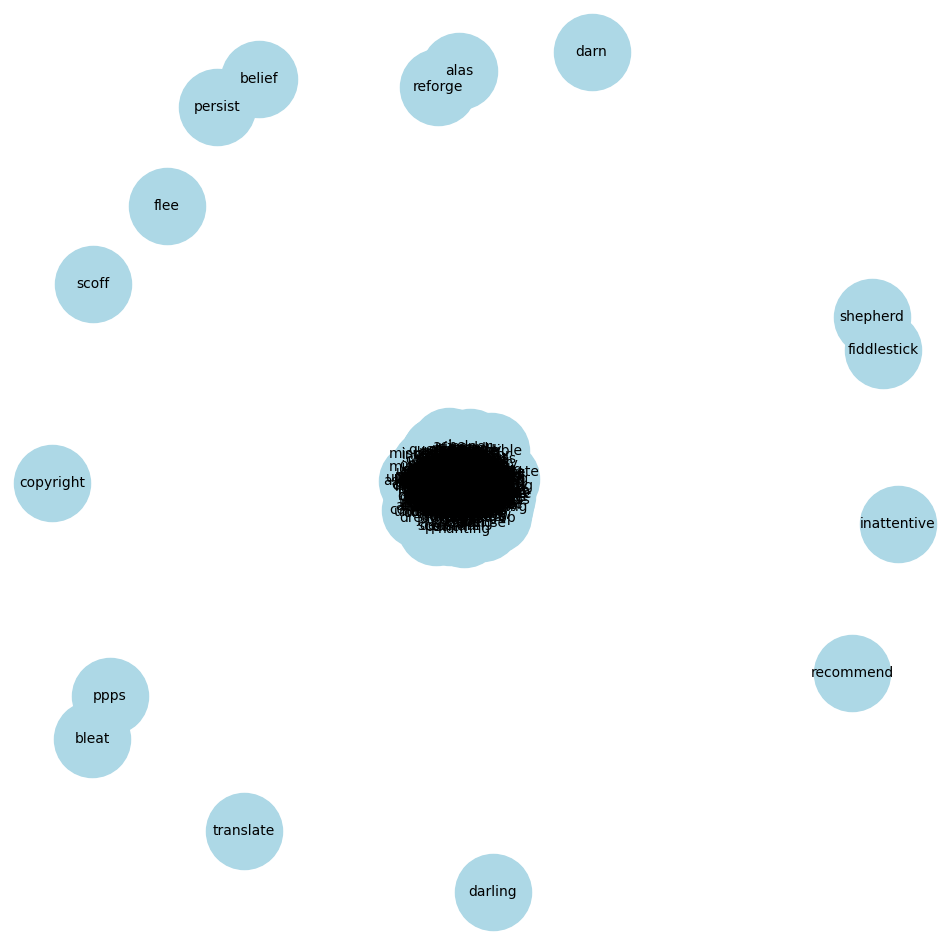

In [7]:
red_global = nx.Graph()

for red in redes_capitulos:
    red_global = nx.compose(red_global, red)

    pos = nx.spring_layout(red_global)
plt.figure(figsize=(12, 12))
nx.draw_networkx(red_global, pos, node_color='lightblue', with_labels=True, node_size=3000, font_size=10)
plt.axis('off')
plt.show()

In [8]:
#código para ver los nodos totales usando la red global y comprobar que da lo mismo que ants
nodos = {}
for node in red_global.nodes:
    nodos[node] = red_global.degree(node)
print(len(nodos))

4006


In [9]:
#Sacamos el factor de compresion con el porcentaje de nodos que queremos
from nltk.tokenize import sent_tokenize
frases = []
for capitulo in capitulos:
    frases_capitulo = sent_tokenize(capitulo)
    frases.extend(frases_capitulo)
#a continuacion un código con el que hemos comprobado las frases cortas para ver por que salen 20 frases menos en la longitud de resumen que en el libro en el capitulo 3    
"""for frase in frases:
    if len(frase)<15:
        print(frase)"""
nodos = {}
for node in red_global.nodes:
    nodos[node] = red_global.degree(node)
diccionario_ordenado = dict(sorted(nodos.items(), key=lambda x: x[1], reverse=True))
#sacamos un 10% de los nodos(factor de compresión de nodos)
n = int(len(nodos) * 0.01)
# sacamos n nodos
nodos_importantes = [clave for clave,valor in diccionario_ordenado.items()][:n]
resumen = []
for frase in frases:
    for nodo in nodos_importantes:
        if nodo in frase:
            if frase not in resumen:
                resumen.append(frase)
print(len(resumen))#código paar comprobar la longitud del resumen

8680


In [10]:
#Sacamos el factor de compresión de las frases una vez aplicado el factor de compresión de los nodos
dic_frases = {}
for i, frase in enumerate(resumen):
    suma = 0
    for node in nodos:
        if node in frase:
            suma += nodos[node]
    dic_frases[i] = (frase, suma)
    
frases_ordenadas = sorted(dic_frases.items(), key=lambda x: x[1][1], reverse=True)
n = int(len(resumen) * 0.1)  # Factor de compresión
# Toma las primeras n frases ordenadas por la suma de grados de nodos
top_indices = [index for index, (_, _) in frases_ordenadas[:n]]
# Ordena los índices de las frases seleccionadas para mantener el orden original
top_indices.sort()
# Obtén las frases con los índices ordenados
top_frases = [resumen[index] for index in top_indices]


In [16]:
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet

# Importa canvas para personalizar el dibujo en cada página
from reportlab.pdfgen import canvas

def add_image_on_page(canvas, doc):
    # Reemplaza 'ruta/al/imagen.png' con la ruta a la imagen que deseas agregar
    img_path = 'Gollum.jpg'
    img = Image(img_path)
    
    # Ajusta el tamaño de la imagen
    scale_factor = 0.2  # Ajusta este valor para cambiar el tamaño de la imagen (0.5 significa 50%)
    img.drawWidth = img.drawWidth * scale_factor
    img.drawHeight = img.drawHeight * scale_factor
    
    # Calcula las coordenadas x, y para colocar la imagen en la parte inferior derecha
    x = doc.pagesize[0] - img.drawWidth - 10  # Ajusta '10' para cambiar el margen derecho
    y = 10  # Ajusta '10' para cambiar el margen inferior

    # Dibuja la imagen en las coordenadas especificadas
    img.drawOn(canvas, x, y)

# Creamos un nuevo archivo PDF
doc = SimpleDocTemplate("Resumen_La_comunidad_del_anillo.pdf", pagesize=letter)

# Establecemos el estilo de los párrafos
styles = getSampleStyleSheet()
style = styles["Normal"]

# Añadimos las frases al archivo PDF como párrafos
story = []
for frase in top_frases:
    story.append(Paragraph(frase, style))
    story.append(Spacer(1, 12))  # Esto es para añadir espacio entre lineas

# Construimos el PDF con las frases
doc.build(story, onFirstPage=add_image_on_page, onLaterPages=add_image_on_page)

print("PDF generado con éxito.")

PDF generado con éxito.
